In [2]:
from __future__ import division
import numpy as np
from cosmology_models import LCDM
import scipy
from  scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from scipy import constants as const
import time 
from matplotlib import cm
import matplotlib

c = const.c       #speed of light (in m/s)
c_km = c/1000     #speed of light (in km/s)

In [3]:
rc_params = {'axes.labelsize': 18,
             'axes.titlesize': 18,
             'font.size': 18,
             'lines.linewidth' : 3,
             'legend.fontsize': 18,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'text.usetex' : True,
            }
rcParams.update(rc_params)

from matplotlib import rc

rc('text.latex', preamble='\\usepackage{txfonts}')
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)

## Reproducing ln$B^L_U = 1.15$ (log$_{10}B^L_U = 0.5$)

... 0 - H1L1V1_O3a_psd
... 1 -- H1L1V1_O2_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes us

... 2 : H1L1_O1_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes us

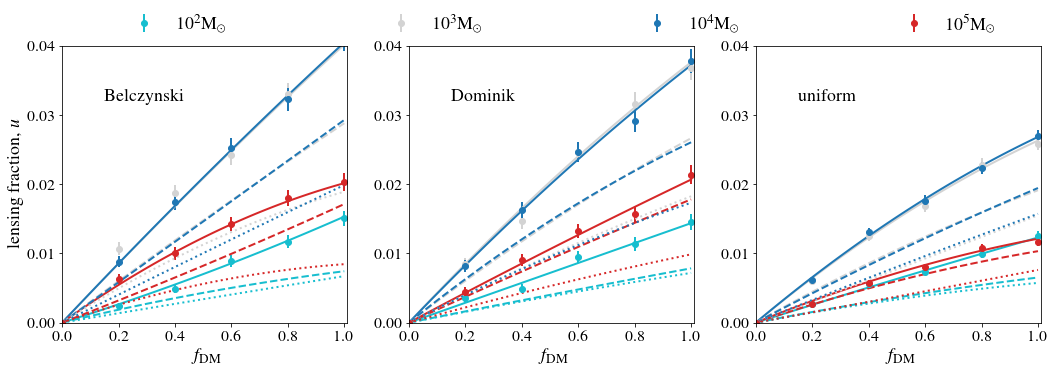

In [102]:
path_plot = '../sim_data/soummyadip_1/plots/final/'

mass_dist_pwl_index = -2.35
approx = 'IMRPhenomD'
N_sim = int(1e7)
y0 = 5
    
zs_dist_vec = ['Belczynski', 'Dominik', 'uniform']
#zs_dist_vec = ['uniform']

f_dm_vec = [1, 0.8, 0.6, 0.4, 0.2]
blu_thresh = 1.15 

resultstag = 'O1O2O3a_bluthresh_%4.2f_constr_min_plaw_%3.2f_2021-12-24' %(blu_thresh, mass_dist_pwl_index)

lens_det_frac_vec = np.zeros_like(f_dm_vec)
lens_det_frac_err_vec = np.zeros_like(f_dm_vec)

plt.figure(figsize=(15,5.5))


xvec = np.linspace(0, 1, 100)
pol_coeff = {}
lens_frac = {}

lsvec = ['-', '--', ':']

for i_p, psd_model in enumerate(['H1L1V1_O3a_psd', 'H1L1V1_O2_psd', 'H1L1_O1_psd']):
    
    print ('...', i_p, lsvec[i_p], psd_model)
    
    # O1 simulations 
    if psd_model == 'H1L1_O1_psd': 
        zs_max = 1.2
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data' 
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02

    # O2 simulations 
    elif psd_model == 'H1L1V1_O2_psd':
        zs_max = 1.5
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.03

    # O3a simulations 
    elif psd_model == 'H1L1V1_O3a_psd':
        zs_max = 1.5
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data'       
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.04
        
    else: 
        raise ValueError('unknown psd model')
     
    # plot colors 
    
    m_lens_vec_req = [100,1000,10000,100000]
    pos = np.where(np.in1d(m_lens_vec, m_lens_vec_req))[0]

    evenly_spaced_interval = np.linspace(0, 1, len(m_lens_vec))
    colors = np.array([cm.Dark2(x) for x in evenly_spaced_interval])

    colors_req = ['tab:cyan', 'lightgrey', 'tab:blue', 'tab:red']
    colors_rgba = []
    for i in colors_req:
        colors_rgba.append(matplotlib.colors.to_rgba(i))

    colors[pos] = colors_rgba

    for i_z, zs_dist in enumerate(zs_dist_vec):
        pol_coeff[zs_dist] = {}
        lens_frac[zs_dist] = {}

        plt.subplot(1,3,i_z+1)
        if i_p == 0: 
            plt.text(0.15, 0.8*ymax, zs_dist)
            plt.xlabel('$f_\mathrm{DM}$')
            plt.xlim(0,1.01)
            plt.ylim(0, ymax)    
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8,1])
            plt.yticks([0, 0.01, 0.02, 0.03, 0.04])

            
        for i_m, m_lens in enumerate(m_lens_vec):
            for i, f_dm in enumerate(f_dm_vec): 

                runtag = '%s_%s_plawidx_%.2f_zsmax_%.1f_y0_%.1f_%s_%s_Nsim_%.0e_lw' %(zs_dist,
                                        approx, mass_dist_pwl_index, zs_max, y0, psd_model, date, N_sim)

                fname = '%s/machodm_ffdata_%s_fdm_%.1f_m_lens%.1e.npz' %(data_dir, runtag, f_dm, m_lens)

                try: 
                    D = np.load(fname)
                except: 
                    print(fname)
                else: 
                    num_det = D['num_det'] 
                    lens_idx = D['lens_idx']
                    ln_Blu = D['ln_Blu']
                    wo_idx = D['wo_idx']
                    good_idx = D['good_idx']

                    # fraction of events that can be confidently identified as lensed 
                    num_lensed = len(np.where(ln_Blu > blu_thresh)[0])
                    lens_det_frac_vec[i] = num_lensed/num_det 
                    lens_det_frac_err_vec[i] = (num_lensed**0.5/num_det)*0.9/0.68 # 90% error 

            # do a polynomial fit 
            pol_coeff[zs_dist][m_lens] = np.polyfit(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                                    2)

            # set the constant term to zero so that fdm = 0 will produce u = 0.
            # this is a temporary fix that seems to work well now. - FIXME 
            pol_coeff[zs_dist][m_lens][-1] = 0 

            lens_frac[zs_dist][m_lens] = np.append(lens_det_frac_vec, 0)

            if m_lens == 10 or m_lens == 1e2 or m_lens == 1e3 or m_lens == 1e4 or m_lens == 1e5  or\
               m_lens == 1e6:

                err = num_lensed**0.5/num_det

                if i_p == 0: 
                    plt.errorbar(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                 yerr=np.append(lens_det_frac_err_vec, 0), marker='o', color=colors[i_m],
                                 label='$10^{%d} \mathrm{M_\odot}$' %np.log10(m_lens), lw=0, elinewidth=2)

                pvec = np.polyval(pol_coeff[zs_dist][m_lens], xvec)
                plt.plot(xvec, pvec, color=colors[i_m], ls=lsvec[i_p])

        f_dm_vec_new = np.append(f_dm_vec, 0)

        resultstag_data = '%s_zsmax%.1f_%s_bluthresh_%.2f_constr_min' %(psd_model, zs_max, date, blu_thresh)

        # save data 
        outfile = '../sim_data/soummyadip_1/'+\
                  'posterior_data/machodm_lensing_frac_jacobian_%s.npz' %(resultstag_data)
        np.savez(outfile, f_dm_vec=f_dm_vec_new, lens_frac=lens_frac, pol_coeff=pol_coeff)


plt.subplot(1,3,1)
plt.ylabel('lensing fraction, $u$')
plt.legend(frameon=False, bbox_to_anchor=(0.2,1.02,3.1,0.6), loc="lower left",
           mode="expand", borderaxespad=0, ncol=6)
plt.tight_layout()
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_%s.pdf' %resultstag)
plt.show()

## ln$B^L_U = 1.84$ (log$_{10}B^L_U = 0.8$) (O3b PSD included)

... 0 -. H1L1V1_O3a_psd
... 1 - H1L1V1_O3b_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using

... 2 -- H1L1V1_O2_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using

... 3 : H1L1_O1_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using

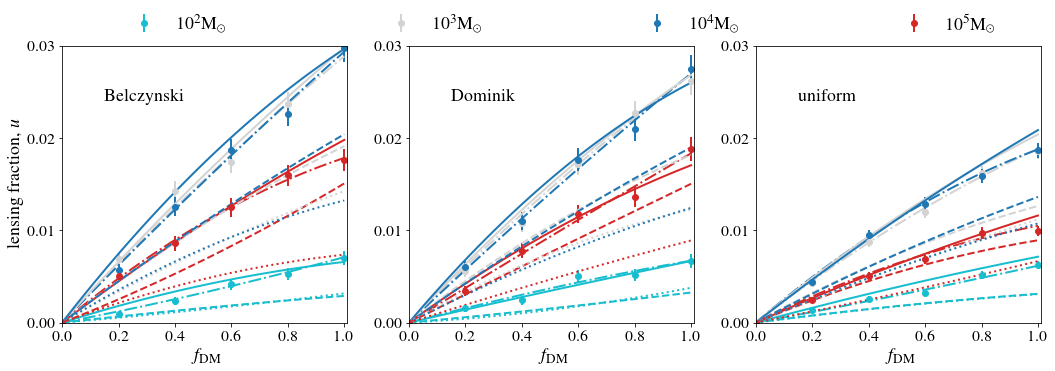

In [104]:
path_plot = '../sim_data/soummyadip_1/plots/final/'

mass_dist_pwl_index = -2.35
approx = 'IMRPhenomD'
N_sim = int(1e7)
y0 = 5
    
zs_dist_vec = ['Belczynski', 'Dominik', 'uniform']

f_dm_vec = [1, 0.8, 0.6, 0.4, 0.2]
blu_thresh = 1.84      # We need to confirm this number with Eungwang

resultstag = 'O1O2O3aO3b_bluthresh_%4.2f_constr_min_plaw_%3.2f_2021-12-24' %(blu_thresh, mass_dist_pwl_index)

lens_det_frac_vec = np.zeros_like(f_dm_vec)
lens_det_frac_err_vec = np.zeros_like(f_dm_vec)

plt.figure(figsize=(15,5.5))


xvec = np.linspace(0, 1, 100)
pol_coeff = {}
lens_frac = {}

lsvec = ['-.', '-', '--', ':']

for i_p, psd_model in enumerate(['H1L1V1_O3a_psd', 'H1L1V1_O3b_psd', 'H1L1V1_O2_psd', 'H1L1_O1_psd']):
    
    print ('...', i_p, lsvec[i_p], psd_model)
    
    # O1 simulations 
    if psd_model == 'H1L1_O1_psd': 
        zs_max = 1.2
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
#         m_lens_vec = np.logspace(2, 5, 4)
        ymax = 0.03

    # O2 simulations 
    elif psd_model == 'H1L1V1_O2_psd':
        zs_max = 1.5
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
#         m_lens_vec = np.logspace(2, 5, 4)
        ymax = 0.03

    # O3a simulations 
    elif psd_model == 'H1L1V1_O3a_psd':
        zs_max = 1.5
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.03
        
    # O3b simulations 
    elif psd_model == 'H1L1V1_O3b_psd':
        zs_max = 1.5
        date = '2021-12-24'
        data_dir = '../sim_data/soummyadip_1/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.03

    else: 
        raise ValueError('unknown psd model')
     
    # plot colors 
    m_lens_vec_req = [100,1000,10000,100000]
    pos = np.where(np.in1d(m_lens_vec, m_lens_vec_req))[0]

    evenly_spaced_interval = np.linspace(0, 1, len(m_lens_vec))
    colors = np.array([cm.Dark2(x) for x in evenly_spaced_interval])

    colors_req = ['tab:cyan', 'lightgrey', 'tab:blue', 'tab:red']
    colors_rgba = []
    for i in colors_req:
        colors_rgba.append(matplotlib.colors.to_rgba(i))

    colors[pos] = colors_rgba

    for i_z, zs_dist in enumerate(zs_dist_vec):
        pol_coeff[zs_dist] = {}
        lens_frac[zs_dist] = {}

        plt.subplot(1,3,i_z+1)
        if i_p == 0: 
            plt.text(0.15, 0.8*ymax, zs_dist)
            plt.xlabel('$f_\mathrm{DM}$')
            plt.xlim(0,1.01)
            plt.ylim(0, ymax)    
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8,1])
            plt.yticks([0, 0.01, 0.02, 0.03])

            
        for i_m, m_lens in enumerate(m_lens_vec):
            for i, f_dm in enumerate(f_dm_vec): 

                runtag = '%s_%s_plawidx_%.2f_zsmax_%.1f_y0_%.1f_%s_%s_Nsim_%.0e_lw' %(zs_dist,
                                        approx, mass_dist_pwl_index, zs_max, y0, psd_model, date, N_sim)

                fname = '%s/machodm_ffdata_%s_fdm_%.1f_m_lens%.1e.npz' %(data_dir, runtag, f_dm, m_lens)

                try: 
                    D = np.load(fname)
                except: 
                    print(fname)
                else: 
                    num_det = D['num_det'] 
                    lens_idx = D['lens_idx']
                    ln_Blu = D['ln_Blu']
                    wo_idx = D['wo_idx']
                    good_idx = D['good_idx']

                    # fraction of events that can be confidently identified as lensed 
                    num_lensed = len(np.where(ln_Blu > blu_thresh)[0])
                    lens_det_frac_vec[i] = num_lensed/num_det 
                    lens_det_frac_err_vec[i] = (num_lensed**0.5/num_det)*0.9/0.68 # 90% error 

            # do a polynomial fit 
            pol_coeff[zs_dist][m_lens] = np.polyfit(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                                    2)

            # set the constant term to zero so that fdm = 0 will produce u = 0.
            # this is a temporary fix that seems to work well now. - FIXME 
            pol_coeff[zs_dist][m_lens][-1] = 0 

            lens_frac[zs_dist][m_lens] = np.append(lens_det_frac_vec, 0)

            if m_lens == 10 or m_lens == 1e2 or m_lens == 1e3 or m_lens == 1e4 or m_lens == 1e5  or\
               m_lens == 1e6:

                err = num_lensed**0.5/num_det

                if i_p == 0: 
                    plt.errorbar(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                 yerr=np.append(lens_det_frac_err_vec, 0), marker='o', color=colors[i_m],
                                 label='$10^{%d} \mathrm{M_\odot}$' %np.log10(m_lens), lw=0, elinewidth=2)
                #else: 
                #    plt.errorbar(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                #                 yerr=np.append(lens_det_frac_err_vec, 0), marker='o', color=colors[i_m],
                #                 lw=0, elinewidth=2)
                    
                pvec = np.polyval(pol_coeff[zs_dist][m_lens], xvec)
                plt.plot(xvec, pvec, color=colors[i_m], ls=lsvec[i_p])

        f_dm_vec_new = np.append(f_dm_vec, 0)

        resultstag_data = '%s_zsmax%.1f_%s_bluthresh_%.2f_constr_min' %(psd_model, zs_max, date, blu_thresh)

        # save data 
        outfile = '../sim_data/soummyadip_1/'+\
                  'posterior_data/machodm_lensing_frac_jacobian_%s.npz' %(resultstag_data)
        np.savez(outfile, f_dm_vec=f_dm_vec_new, lens_frac=lens_frac, pol_coeff=pol_coeff)

plt.subplot(1,3,1)
plt.ylabel('lensing fraction, $u$')
plt.legend(frameon=False, bbox_to_anchor=(0.2,1.02,3.1,0.6), loc="lower left",
                mode="expand", borderaxespad=0, ncol=6)
plt.tight_layout()
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_%s.pdf' %resultstag)
plt.show()

## ln$B^L_U = 1.15$ (log$_{10}B^L_U = 0.5$) including proper redshift and source mass distributions (till O3a)

... 0 - H1L1V1_O3a_psd
... 1 -- H1L1V1_O2_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using

... 2 : H1L1_O1_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using

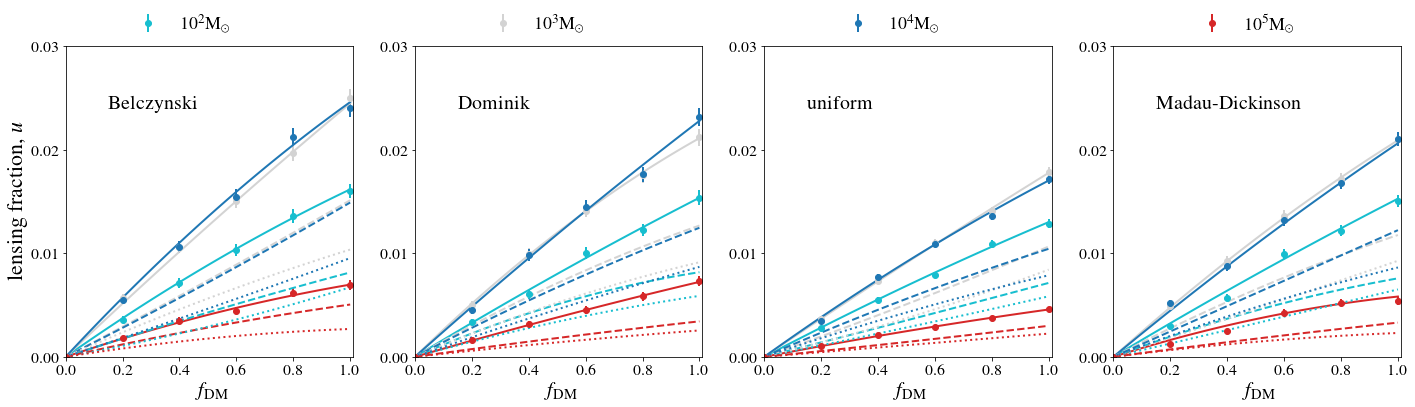

In [13]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# mass_dist_pwl_index = -2.35
mass_dist = 'power_law_peak'
approx = 'IMRPhenomD'
N_sim = int(1e7)
y0 = 5
    
zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

f_dm_vec = [1, 0.8, 0.6, 0.4, 0.2]
blu_thresh = 1.15 

resultstag = 'O1O2O3a_bluthresh_%4.2f_constr_min_plaw_%s_2022-01-10' %(blu_thresh, mass_dist)

lens_det_frac_vec = np.zeros_like(f_dm_vec)
lens_det_frac_err_vec = np.zeros_like(f_dm_vec)

plt.figure(figsize=(20,6))

xvec = np.linspace(0, 1, 100)
pol_coeff = {}
lens_frac = {}

lsvec = ['-', '--', ':']

for i_p, psd_model in enumerate(['H1L1V1_O3a_psd', 'H1L1V1_O2_psd', 'H1L1_O1_psd']):
    
    print ('...', i_p, lsvec[i_p], psd_model)
    
    # O1 simulations 
    if psd_model == 'H1L1_O1_psd': 
        zs_max = 1.2
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.03

    # O2 simulations 
    elif psd_model == 'H1L1V1_O2_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.03

    # O3a simulations 
    elif psd_model == 'H1L1V1_O3a_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'         
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.03
        
    else: 
        raise ValueError('unknown psd model')
     
    # plot colors 
    
    m_lens_vec_req = [100,1000,10000,100000]
    pos = np.where(np.in1d(m_lens_vec, m_lens_vec_req))[0]

    evenly_spaced_interval = np.linspace(0, 1, len(m_lens_vec))
    colors = np.array([cm.Dark2(x) for x in evenly_spaced_interval])

    colors_req = ['tab:cyan', 'lightgrey', 'tab:blue', 'tab:red']
    colors_rgba = []
    for i in colors_req:
        colors_rgba.append(matplotlib.colors.to_rgba(i))

    colors[pos] = colors_rgba

    for i_z, zs_dist in enumerate(zs_dist_vec):
        pol_coeff[zs_dist] = {}
        lens_frac[zs_dist] = {}

        plt.subplot(1,4,i_z+1)
        if i_p == 0: 
            plt.text(0.15, 0.8*ymax, [zs_dist if zs_dist == 'Belczynski' or zs_dist == 'Dominik' or \
                                      zs_dist == 'uniform' else 'Madau-Dickinson'][0], fontsize=20)
            plt.xlabel('$f_\mathrm{DM}$', fontsize=20)
            plt.xlim(0,1.01)
            plt.ylim(0, ymax)    
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.yticks([0, 0.01, 0.02, 0.03])

        for i_m, m_lens in enumerate(m_lens_vec):
            for i, f_dm in enumerate(f_dm_vec): 

                runtag = '%s_%s_plawidx_%s_zsmax_%.1f_y0_%.1f_%s_%s_Nsim_%.0e_lw' %(zs_dist,
                                        approx, mass_dist, zs_max, y0, psd_model, date, N_sim)

                fname = '%s/machodm_ffdata_%s_fdm_%.1f_m_lens_%.1e.npz' %(data_dir, runtag, f_dm, m_lens)

                try: 
                    D = np.load(fname)
                except: 
                    print(fname)
                else: 
                    num_det = D['num_det'] 
                    lens_idx = D['lens_idx']
                    ln_Blu = D['ln_Blu']
                    wo_idx = D['wo_idx']
                    good_idx = D['good_idx']

                    # fraction of events that can be confidently identified as lensed 
                    num_lensed = len(np.where(ln_Blu > blu_thresh)[0])
                    lens_det_frac_vec[i] = num_lensed/num_det 
                    lens_det_frac_err_vec[i] = (num_lensed**0.5/num_det)*0.9/0.68 # 90% error 

            # do a polynomial fit 
            pol_coeff[zs_dist][m_lens] = np.polyfit(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                                    2)

            # set the constant term to zero so that fdm = 0 will produce u = 0.
            # this is a temporary fix that seems to work well now. - FIXME 
            pol_coeff[zs_dist][m_lens][-1] = 0 

            lens_frac[zs_dist][m_lens] = np.append(lens_det_frac_vec, 0)

            if m_lens == 10 or m_lens == 1e2 or m_lens == 1e3 or m_lens == 1e4 or m_lens == 1e5  or\
               m_lens == 1e6:

                err = num_lensed**0.5/num_det

                if i_p == 0: 
                    plt.errorbar(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                 yerr=np.append(lens_det_frac_err_vec, 0), marker='o', color=colors[i_m],
                                 label='$10^{%d} \mathrm{M_\odot}$' %np.log10(m_lens), lw=0, elinewidth=2)
                    
                pvec = np.polyval(pol_coeff[zs_dist][m_lens], xvec)
                plt.plot(xvec, pvec, color=colors[i_m], ls=lsvec[i_p])

        f_dm_vec_new = np.append(f_dm_vec, 0)

        resultstag_data = '%s_zsmax%.1f_%s_bluthresh_%.2f_constr_min' %(psd_model, zs_max, date, blu_thresh)

        # save data 
        outfile = '../sim_data/soummyadip_o3b/'+\
                  'posterior_data/machodm_lensing_frac_jacobian_%s.npz' %(resultstag_data)
        np.savez(outfile, f_dm_vec=f_dm_vec_new, lens_frac=lens_frac, pol_coeff=pol_coeff)


plt.subplot(1,4,1)
plt.ylabel('lensing fraction, $u$', fontsize=22)
plt.legend(frameon=False, bbox_to_anchor=(0.2,1.02,4.1,0.6), loc="lower left",
           mode="expand", borderaxespad=0, ncol=6)
plt.tight_layout()
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_%s.pdf' %resultstag)
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_%s.png' %resultstag)
plt.show()

# This is the main part for (inluding) the O3b analysis and for the review purpose. 

## ln$B^L_U = 1.84$ (log$_{10}B^L_U = 0.8$) including proper redshift and source mass distributions (including O3b PSD)

... 0 -. H1L1V1_O3b_psd
... 1 - H1L1V1_O3a_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using

... 2 -- H1L1V1_O2_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using

... 3 : H1L1_O1_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using

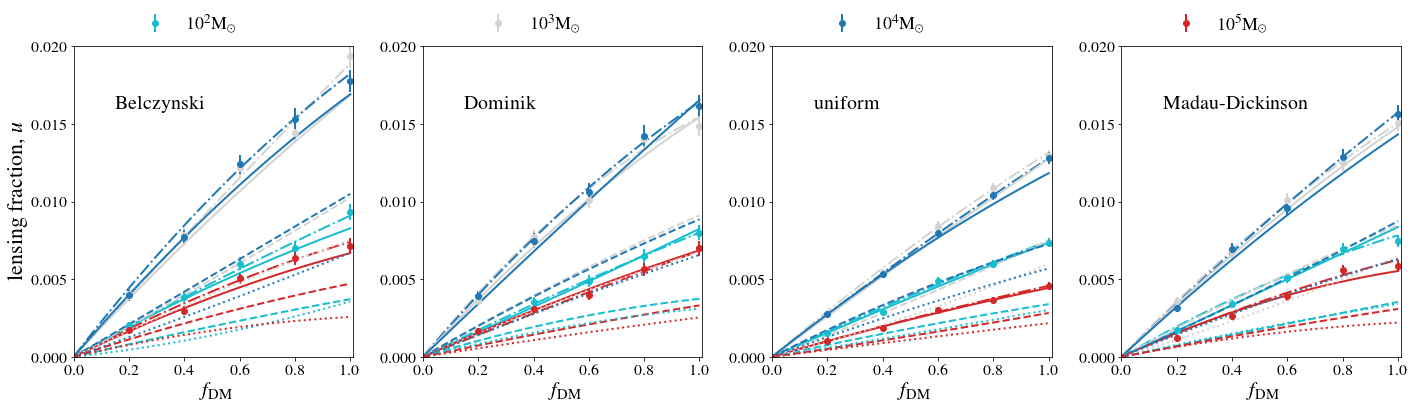

In [14]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# mass_dist_pwl_index = -2.35
mass_dist = 'power_law_peak'
approx = 'IMRPhenomD'
N_sim = int(1e7)
y0 = 5
    
zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

f_dm_vec = [1, 0.8, 0.6, 0.4, 0.2]
blu_thresh = 1.84     # We need to confirm this number with Eungwang

resultstag = 'O1O2O3aO3b_bluthresh_%4.2f_constr_min_plaw_%s_2022-01-10' %(blu_thresh, mass_dist)

lens_det_frac_vec = np.zeros_like(f_dm_vec)
lens_det_frac_err_vec = np.zeros_like(f_dm_vec)

plt.figure(figsize=(20,6))

xvec = np.linspace(0, 1, 100)
pol_coeff = {}
lens_frac = {}

lsvec = ['-.', '-', '--', ':']

for i_p, psd_model in enumerate(['H1L1V1_O3b_psd', 'H1L1V1_O3a_psd', 'H1L1V1_O2_psd', 'H1L1_O1_psd']):
    
    print ('...', i_p, lsvec[i_p], psd_model)
    
    # O1 simulations 
    if psd_model == 'H1L1_O1_psd': 
        zs_max = 1.2
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02

    # O2 simulations 
    elif psd_model == 'H1L1V1_O2_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02

    # O3a simulations 
    elif psd_model == 'H1L1V1_O3a_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'         
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02
        
    # O3b simulations 
    elif psd_model == 'H1L1V1_O3b_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'         
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02
        
    else: 
        raise ValueError('unknown psd model')
     
    # plot colors 
    
    m_lens_vec_req = [100,1000,10000,100000]
    pos = np.where(np.in1d(m_lens_vec, m_lens_vec_req))[0]

    evenly_spaced_interval = np.linspace(0, 1, len(m_lens_vec))
    colors = np.array([cm.Dark2(x) for x in evenly_spaced_interval])

    colors_req = ['tab:cyan', 'lightgrey', 'tab:blue', 'tab:red']
    colors_rgba = []
    for i in colors_req:
        colors_rgba.append(matplotlib.colors.to_rgba(i))

    colors[pos] = colors_rgba

    for i_z, zs_dist in enumerate(zs_dist_vec):
        pol_coeff[zs_dist] = {}
        lens_frac[zs_dist] = {}

        plt.subplot(1,4,i_z+1)
        if i_p == 0: 
            plt.text(0.15, 0.8*ymax, [zs_dist if zs_dist == 'Belczynski' or zs_dist == 'Dominik' or \
                                      zs_dist == 'uniform' else 'Madau-Dickinson'][0], fontsize=20)
            plt.xlabel('$f_\mathrm{DM}$', fontsize=20)
            plt.xlim(0,1.01)
            plt.ylim(0, ymax)    
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.yticks([0, 0.005, 0.01, 0.015, 0.02])

        for i_m, m_lens in enumerate(m_lens_vec):
            for i, f_dm in enumerate(f_dm_vec): 

                runtag = '%s_%s_plawidx_%s_zsmax_%.1f_y0_%.1f_%s_%s_Nsim_%.0e_lw' %(zs_dist,
                                        approx, mass_dist, zs_max, y0, psd_model, date, N_sim)

                fname = '%s/machodm_ffdata_%s_fdm_%.1f_m_lens_%.1e.npz' %(data_dir, runtag, f_dm, m_lens)

                try: 
                    D = np.load(fname)
                except: 
                    print(fname)
                else: 
                    num_det = D['num_det'] 
                    lens_idx = D['lens_idx']
                    ln_Blu = D['ln_Blu']
                    wo_idx = D['wo_idx']
                    good_idx = D['good_idx']

                    # fraction of events that can be confidently identified as lensed 
                    num_lensed = len(np.where(ln_Blu > blu_thresh)[0])
                    lens_det_frac_vec[i] = num_lensed/num_det 
                    lens_det_frac_err_vec[i] = (num_lensed**0.5/num_det)*0.9/0.68 # 90% error 

            # do a polynomial fit 
            pol_coeff[zs_dist][m_lens] = np.polyfit(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                                    2)

            # set the constant term to zero so that fdm = 0 will produce u = 0.
            # this is a temporary fix that seems to work well now. - FIXME 
            pol_coeff[zs_dist][m_lens][-1] = 0 

            lens_frac[zs_dist][m_lens] = np.append(lens_det_frac_vec, 0)

            if m_lens == 10 or m_lens == 1e2 or m_lens == 1e3 or m_lens == 1e4 or m_lens == 1e5  or\
               m_lens == 1e6:

                err = num_lensed**0.5/num_det

                if i_p == 0: 
                    plt.errorbar(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                 yerr=np.append(lens_det_frac_err_vec, 0), marker='o', color=colors[i_m],
                                 label='$10^{%d} \mathrm{M_\odot}$' %np.log10(m_lens), lw=0, elinewidth=2)
                    
                pvec = np.polyval(pol_coeff[zs_dist][m_lens], xvec)
                plt.plot(xvec, pvec, color=colors[i_m], ls=lsvec[i_p])

        f_dm_vec_new = np.append(f_dm_vec, 0)

        resultstag_data = '%s_zsmax%.1f_%s_bluthresh_%.2f_constr_min' %(psd_model, zs_max, date, blu_thresh)

        # save data 
        outfile = '../sim_data/soummyadip_o3b/'+\
                  'posterior_data/machodm_lensing_frac_jacobian_%s.npz' %(resultstag_data)
        np.savez(outfile, f_dm_vec=f_dm_vec_new, lens_frac=lens_frac, pol_coeff=pol_coeff)

plt.subplot(1,4,1)
plt.ylabel('lensing fraction, $u$', fontsize=22)
plt.legend(frameon=False, bbox_to_anchor=(0.2,1.02,4.1,0.6), loc="lower left",
           mode="expand", borderaxespad=0, ncol=6)
plt.tight_layout()
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_%s.pdf' %resultstag)
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_%s.png' %resultstag)
plt.show()

... 0 -. H1L1V1_O3b_psd
... 1 - H1L1V1_O3a_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using

... 2 -- H1L1V1_O2_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using

... 3 : H1L1_O1_psd


/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/soummyadip.basak/bilby/ve3/bilby_som/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using

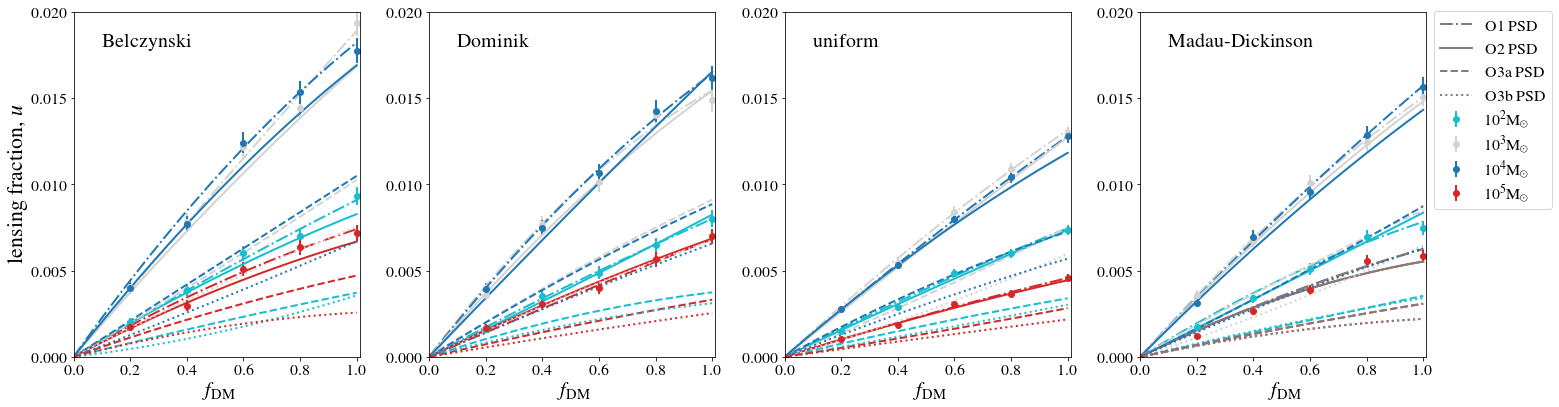

In [60]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# mass_dist_pwl_index = -2.35
mass_dist = 'power_law_peak'
approx = 'IMRPhenomD'
N_sim = int(1e7)
y0 = 5
    
zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

f_dm_vec = [1, 0.8, 0.6, 0.4, 0.2]
blu_thresh = 1.84     # We need to confirm this number with Eungwang

resultstag = 'O1O2O3aO3b_bluthresh_%4.2f_constr_min_plaw_%s_2022-01-10' %(blu_thresh, mass_dist)

lens_det_frac_vec = np.zeros_like(f_dm_vec)
lens_det_frac_err_vec = np.zeros_like(f_dm_vec)

plt.figure(figsize=(22,6))

xvec = np.linspace(0, 1, 100)
pol_coeff = {}
lens_frac = {}

lsvec = ['-.', '-', '--', ':']
psd_text = ['-.- O1 PSD', '--- O2 PSD', '-s-s- O3a PSD', '..... O3b PSD']

for i_p, psd_model in enumerate(['H1L1V1_O3b_psd', 'H1L1V1_O3a_psd', 'H1L1V1_O2_psd', 'H1L1_O1_psd']):
    
    print ('...', i_p, lsvec[i_p], psd_model)
    
    # O1 simulations 
    if psd_model == 'H1L1_O1_psd': 
        zs_max = 1.2
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02          # Here ymax is for the y-axis limit (maximum)

    # O2 simulations 
    elif psd_model == 'H1L1V1_O2_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02

    # O3a simulations 
    elif psd_model == 'H1L1V1_O3a_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'         
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02
        
    # O3b simulations 
    elif psd_model == 'H1L1V1_O3b_psd':
        zs_max = 1.5
        date = '2022-01-10'
        data_dir = '../sim_data/soummyadip_o3b/ff_data'         
        m_lens_vec = np.logspace(2, 5, 13)
        ymax = 0.02
        
    else: 
        raise ValueError('unknown psd model')
     
    # plot colors 
    
    m_lens_vec_req = [100,1000,10000,100000]
    pos = np.where(np.in1d(m_lens_vec, m_lens_vec_req))[0]

    evenly_spaced_interval = np.linspace(0, 1, len(m_lens_vec))
    colors = np.array([cm.Dark2(x) for x in evenly_spaced_interval])

    colors_req = ['tab:cyan', 'lightgrey', 'tab:blue', 'tab:red']
    colors_rgba = []
    for i in colors_req:
        colors_rgba.append(matplotlib.colors.to_rgba(i))

    colors[pos] = colors_rgba

    for i_z, zs_dist in enumerate(zs_dist_vec):
        pol_coeff[zs_dist] = {}
        lens_frac[zs_dist] = {}

        plt.subplot(1,4,i_z+1)
        if i_p == 0: 
            plt.text(0.1, 0.9*ymax, [zs_dist if zs_dist == 'Belczynski' or zs_dist == 'Dominik' or \
                                      zs_dist == 'uniform' else 'Madau-Dickinson'][0], fontsize=20)
            plt.xlabel('$f_\mathrm{DM}$', fontsize=20)
            plt.xlim(0,1.01)
            plt.ylim(0, ymax)    
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.yticks([0, 0.005, 0.01, 0.015, 0.02])

        for i_m, m_lens in enumerate(m_lens_vec):
            for i, f_dm in enumerate(f_dm_vec): 

                runtag = '%s_%s_plawidx_%s_zsmax_%.1f_y0_%.1f_%s_%s_Nsim_%.0e_lw' %(zs_dist,
                                        approx, mass_dist, zs_max, y0, psd_model, date, N_sim)

                fname = '%s/machodm_ffdata_%s_fdm_%.1f_m_lens_%.1e.npz' %(data_dir, runtag, f_dm, m_lens)

                try: 
                    D = np.load(fname)
                except: 
                    print(fname)
                else: 
                    num_det = D['num_det'] 
                    lens_idx = D['lens_idx']
                    ln_Blu = D['ln_Blu']
                    wo_idx = D['wo_idx']
                    good_idx = D['good_idx']

                    # fraction of events that can be confidently identified as lensed 
                    num_lensed = len(np.where(ln_Blu > blu_thresh)[0])
                    lens_det_frac_vec[i] = num_lensed/num_det 
                    lens_det_frac_err_vec[i] = (num_lensed**0.5/num_det)*0.9/0.68 # 90% error 

            # do a polynomial fit 
            pol_coeff[zs_dist][m_lens] = np.polyfit(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                                    2)

            # set the constant term to zero so that fdm = 0 will produce u = 0.
            # this is a temporary fix that seems to work well now. - FIXME 
            pol_coeff[zs_dist][m_lens][-1] = 0 

            lens_frac[zs_dist][m_lens] = np.append(lens_det_frac_vec, 0)

            if m_lens == 10 or m_lens == 1e2 or m_lens == 1e3 or m_lens == 1e4 or m_lens == 1e5  or\
               m_lens == 1e6:

                err = num_lensed**0.5/num_det

                if i_p == 0: 
                    plt.errorbar(np.append(f_dm_vec, 0), np.append(lens_det_frac_vec, 0),\
                                 yerr=np.append(lens_det_frac_err_vec, 0), marker='o', color=colors[i_m],
                                 label='$10^{%d} \mathrm{M_\odot}$' %np.log10(m_lens), lw=0, elinewidth=2)
                    
                pvec = np.polyval(pol_coeff[zs_dist][m_lens], xvec)
                plt.plot(xvec, pvec, color=colors[i_m], ls=lsvec[i_p])

        f_dm_vec_new = np.append(f_dm_vec, 0)

        resultstag_data = '%s_zsmax%.1f_%s_bluthresh_%.2f_constr_min' %(psd_model, zs_max, date, blu_thresh)

        # save data 
        outfile = '../sim_data/soummyadip_o3b/'+\
                  'posterior_data/machodm_lensing_frac_jacobian_%s.npz' %(resultstag_data)
        np.savez(outfile, f_dm_vec=f_dm_vec_new, lens_frac=lens_frac, pol_coeff=pol_coeff)
        
#     plt.text(0.1, (0.8-i_p*0.1)*ymax, s=psd_text[i_p])
    plt.plot(xvec, pvec, label=['O1 PSD' if i_p == 0 else 'O2 PSD' if i_p == 1\
             else 'O3a PSD' if i_p == 2 else 'O3b PSD'][0], ls=lsvec[i_p], color='tab:grey')

plt.legend(fontsize=16, bbox_to_anchor=(1,1.025), loc='upper left')
plt.subplot(1,4,1)
plt.ylabel('lensing fraction, $u$', fontsize=22)
# plt.legend(frameon=False, bbox_to_anchor=(0.2,1.02,4.1,0.6), loc="lower left",
#            mode="expand", borderaxespad=0, ncol=6)
plt.tight_layout()
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_psd_legend_included%s.pdf' %resultstag)
plt.savefig(path_plot+'machodm_lensing_frac_jacobian_psd_legend_included%s.png' %resultstag)
plt.show()